In [ ]:
import os
import librosa
import numpy as np

# Set the directory containing the audio files
data_dir = './inpainting_data' 

# Get the paths of all the audio files
def get_audio_file_paths(data_dir):
    audio_file_paths = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.mp3'):
                audio_file_paths.append(os.path.join(root, file))
    return audio_file_paths

audio_file_paths = get_audio_file_paths(data_dir)


In [ ]:
def introduce_gaps(audio, sr, gap_duration=0.5):
    audio_length = len(audio)
    gap_samples = int(gap_duration * sr)
    start = np.random.randint(0, audio_length - gap_samples)
    audio_with_gaps = audio.copy()
    audio_with_gaps[start:start+gap_samples] = 0  # Set gap to 0 (silence)
    return audio_with_gaps


In [6]:
def audio_to_spectrogram(audio, sr, n_fft=2048, hop_length=512):
    spectrogram = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    spectrogram_magnitude = np.abs(spectrogram)
    return spectrogram_magnitude


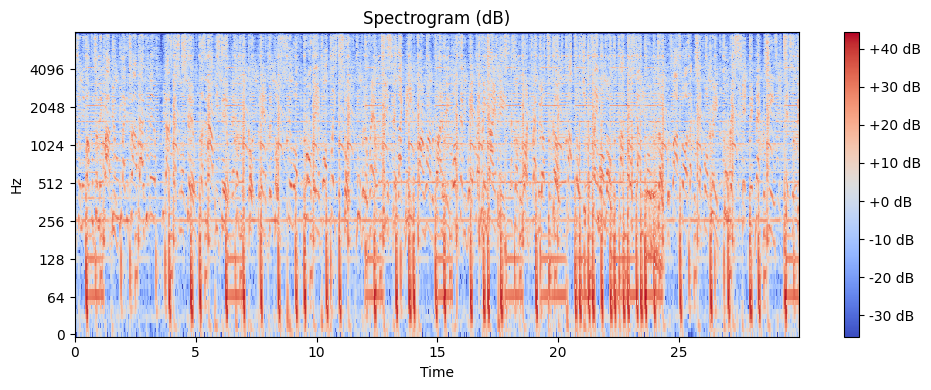

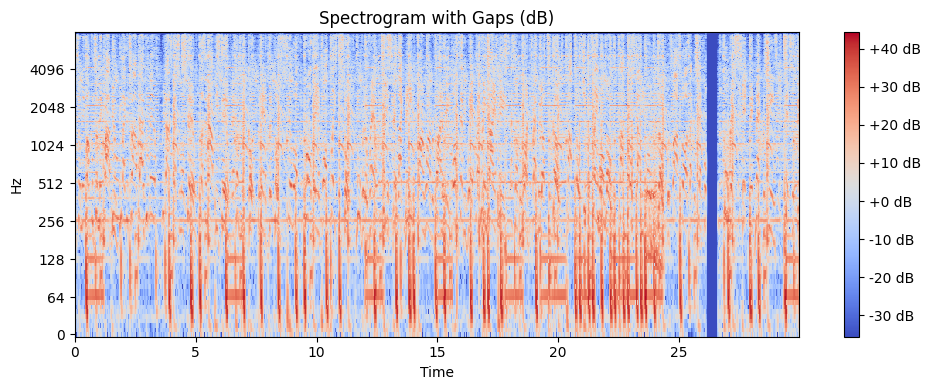

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# load audio file
file_path = audio_file_paths[0]  # pick the first audio file for showing the example
audio, sr = librosa.load(file_path, sr=16000)

# calculate spectrogram
spectrogram = librosa.stft(audio, n_fft=2048, hop_length=512)
spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram))

# visualize the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (dB)')
plt.tight_layout()
plt.show()

# show the gaps in the audio
audio_with_gaps = introduce_gaps(audio, sr, gap_duration=0.5)

# calculate spectrogram of the audio with gaps
spectrogram_with_gaps = librosa.stft(audio_with_gaps, n_fft=2048, hop_length=512)
spectrogram_with_gaps_db = librosa.amplitude_to_db(np.abs(spectrogram_with_gaps))

# visualize the spectrogram of the audio with gaps
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_with_gaps_db, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram with Gaps (dB)')
plt.tight_layout()
plt.show()


In [ ]:
def pad_or_truncate(spectrogram, target_shape):
    pad_width = [(0, max(0, target_shape[0] - spectrogram.shape[0])),
                 (0, max(0, target_shape[1] - spectrogram.shape[1]))]
    if spectrogram.shape[0] > target_shape[0]:
        spectrogram = spectrogram[:target_shape[0], :]
    if spectrogram.shape[1] > target_shape[1]:
        spectrogram = spectrogram[:, :target_shape[1]]
    spectrogram = np.pad(spectrogram, pad_width, mode='constant')
    return spectrogram


spectrograms_input = []
spectrograms_target = []

for file_path in audio_file_paths:
    audio, sr = librosa.load(file_path, sr=16000)
    # introduce gaps
    audio_with_gaps = introduce_gaps(audio, sr)
    # calculate spectrograms
    spectrogram_input = audio_to_spectrogram(audio_with_gaps, sr)
    spectrogram_target = audio_to_spectrogram(audio, sr)
    # pad or truncate the spectrograms to the same shape
    target_shape = (1024, 128)
    spectrogram_input = pad_or_truncate(spectrogram_input, target_shape)
    spectrogram_target = pad_or_truncate(spectrogram_target, target_shape)
    # append to the lists
    spectrograms_input.append(spectrogram_input)
    spectrograms_target.append(spectrogram_target)

# set the numpy arrays
spectrograms_input = np.array(spectrograms_input)
spectrograms_target = np.array(spectrograms_target)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


#model construction
def build_inpainting_model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    
    # encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # decoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    model = models.Model(input_layer, decoded)
    model.compile(optimizer='adam', loss='mse')
    return model

input_shape = (spectrograms_input.shape[1], spectrograms_input.shape[2], 1)
model = build_inpainting_model(input_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024, 128, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 1024, 128, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 512, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 512, 64, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 256, 32, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 32, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 512, 64, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 512, 64, 32)    │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 1024, 128, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1024, 128, 1)   │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 68s 784ms/step - loss: 26.8885 - val_loss: 27.9161
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 62s 760ms/step - loss: 24.3225 - val_loss: 27.8995
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 62s 761ms/step - loss: 24.4190 - val_loss: 27.8911
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 61s 753ms/step - loss: 25.5813 - val_loss: 27.8847
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 60s 740ms/step - loss: 24.6833 - val_loss: 27.8829
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 60s 746ms/step - loss: 26.0690 - val_loss: 27.8801
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 60s 743ms/step - loss: 25.9156 - val_loss: 27.8789
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 60s 737ms/step - loss: 25.0006 - val_loss: 27.8771
Epoch 9/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 60s 745ms/step - loss: 25.8589 - val_loss: 27.8764
Epoch 10/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 61s 757ms/step - loss: 26.0467 - val_loss: 27.8782
Epoch 11/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 61s 750ms/step - loss: 26.1172 - val_loss: 27.8751
Epoch 12/20
81/81 ━

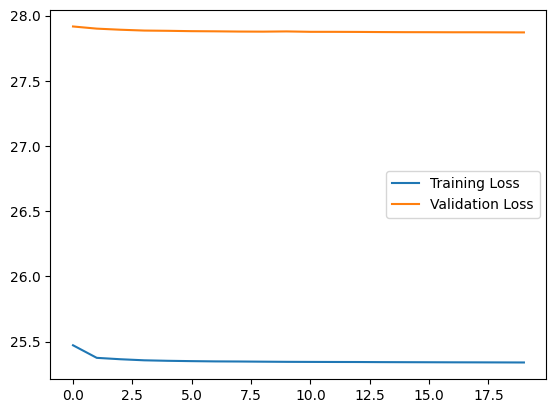

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


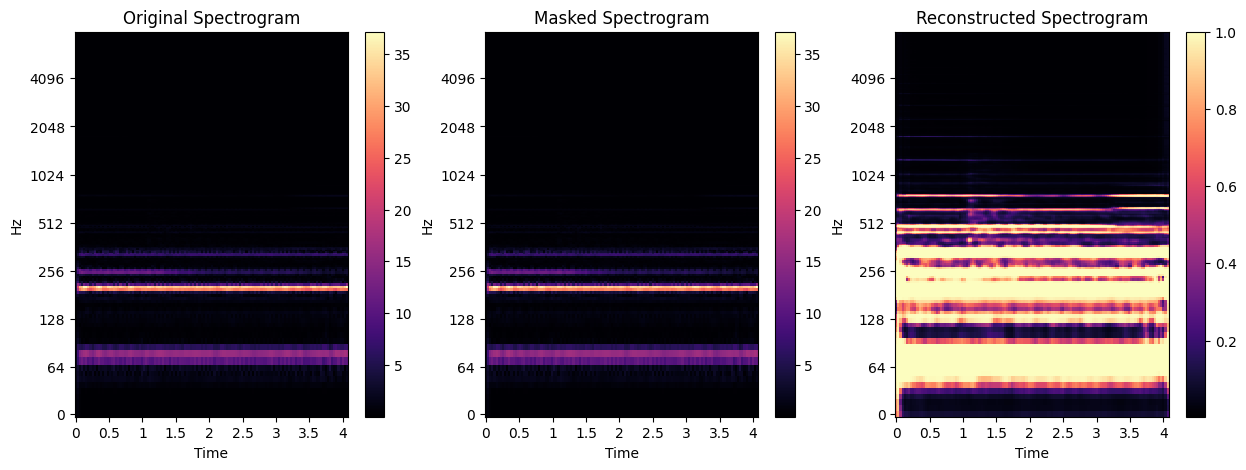

In [ ]:
#data preprocessing

# Add channel dimension
spectrograms_input = np.expand_dims(spectrograms_input, -1)
spectrograms_target = np.expand_dims(spectrograms_target, -1)

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    spectrograms_input, spectrograms_target, test_size=0.2, random_state=42)

#model training
epochs = 20
batch_size = 16

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)

#model evaluation
loss, val_loss = history.history['loss'], history.history['val_loss']

import matplotlib.pyplot as plt

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()


#visualize the inpainting results
def visualize_results(index):
    original = y_val[index].squeeze()
    masked = X_val[index].squeeze()
    reconstructed = model.predict(X_val[index:index+1]).squeeze()
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    librosa.display.specshow(original, sr=16000, x_axis='time', y_axis='log')
    plt.title('Original Spectrogram')
    plt.colorbar()
    
    plt.subplot(1, 3, 2)
    librosa.display.specshow(masked, sr=16000, x_axis='time', y_axis='log')
    plt.title('Masked Spectrogram')
    plt.colorbar()
    
    plt.subplot(1, 3, 3)
    librosa.display.specshow(reconstructed, sr=16000, x_axis='time', y_axis='log')
    plt.title('Reconstructed Spectrogram')
    plt.colorbar()
    
    plt.show()

# visualize the inpainting results for the first example in the validation set
visualize_results(0)


In [ ]:
# def spectrogram_to_audio(spectrogram, sr=16000, n_fft=2048, hop_length=512):
#     # If you applied any scaling or transformations, reverse them here
#     # Use the Griffin-Lim algorithm to reconstruct the phase
#     reconstructed_audio = librosa.griffinlim(
#         spectrogram, n_iter=32, hop_length=hop_length, n_fft=n_fft
#     )
#     return reconstructed_audio

# # Reconstruct the audio
# index = 0  # Sample index
# masked_spectrogram = X_val[index:index+1]
# reconstructed = model.predict(masked_spectrogram).squeeze()

# # Convert to audio
# reconstructed_audio = spectrogram_to_audio(reconstructed)

# # Save the audio
# import soundfile as sf
# sf.write('reconstructed_audio.wav', reconstructed_audio, sr=16000)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


ValueError: could not broadcast input array from shape (1025,128) into shape (1024,128)